In [1]:
# uploading the dataset
import pandas as pd
file=r"C:\Users\ASUS\OneDrive\Documents\Energy_dataset.csv"
try:
    df=pd.read_csv(file)
    print("uploaded!!!")
    
except Exception as e:
    print("not uploaded!!",e)

uploaded!!!


In [17]:
df

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative Compactness       768 non-null    float64
 1   Surface Area               768 non-null    float64
 2   Wall Area                  768 non-null    float64
 3   Roof Area                  768 non-null    float64
 4   Overall Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing Area               768 non-null    float64
 7   Glazing Area Distribution  768 non-null    int64  
 8   Heating Load               768 non-null    float64
 9   Cooling Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


EDA PROCESS

In [3]:
# checking empty cells
df.isnull().sum()

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64

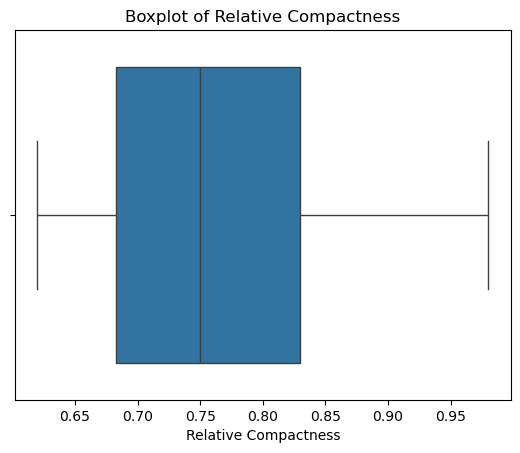

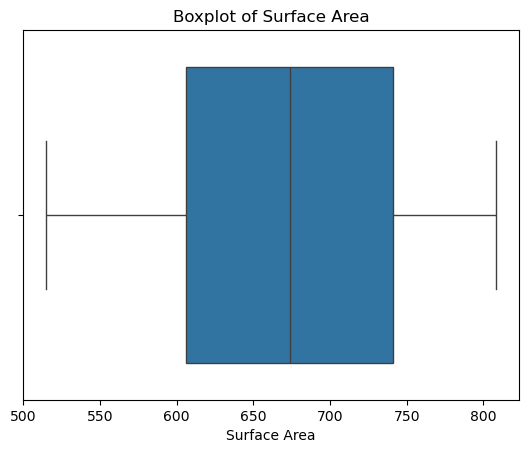

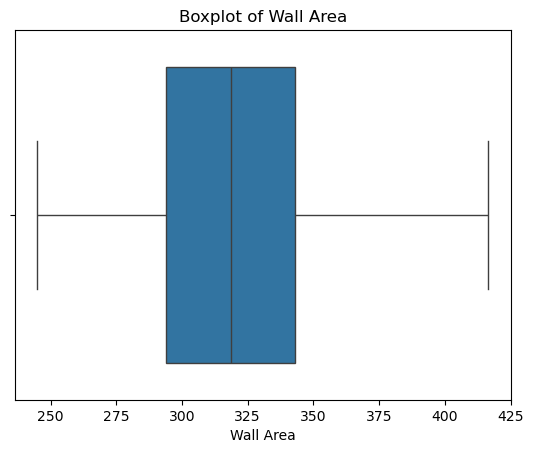

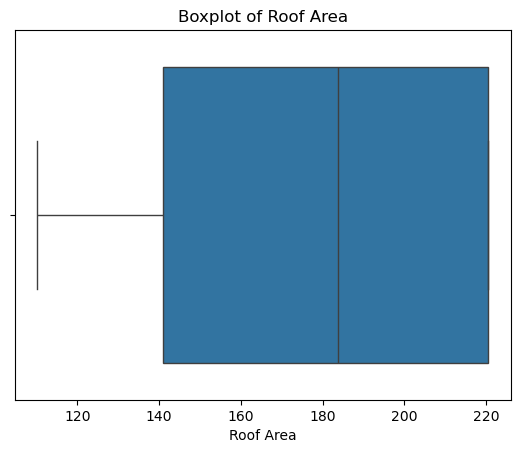

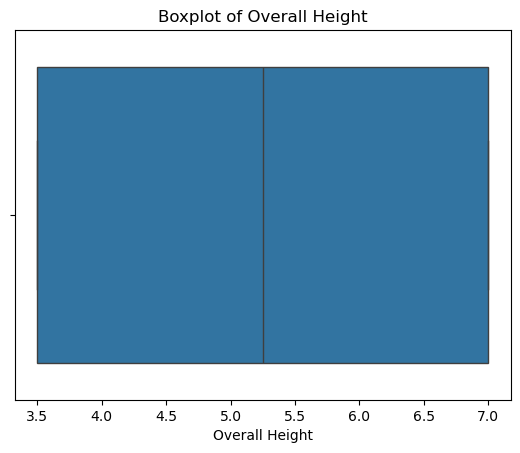

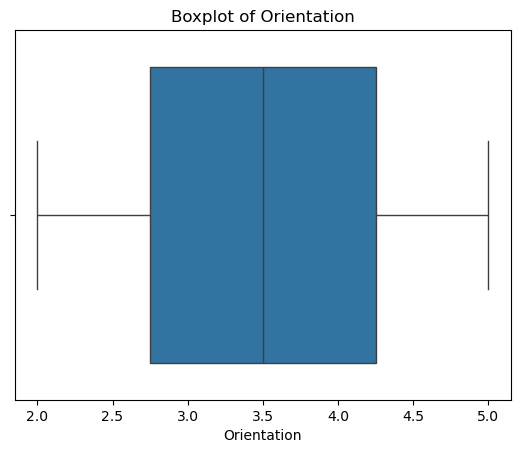

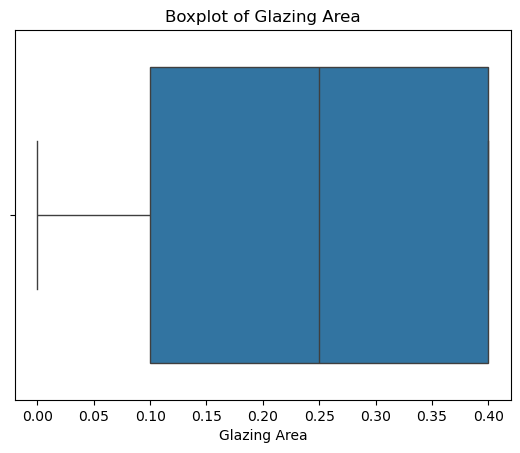

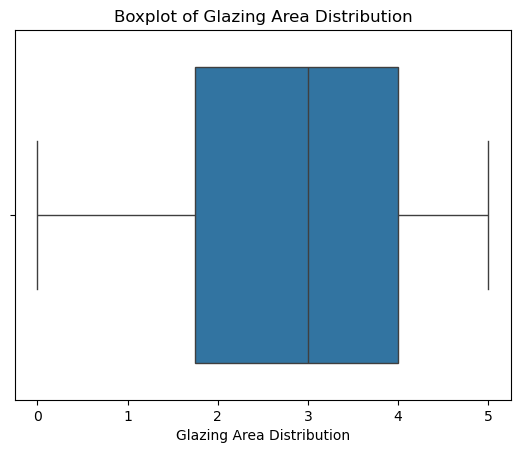

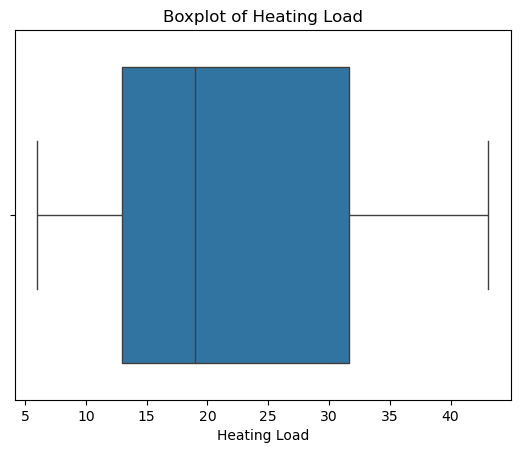

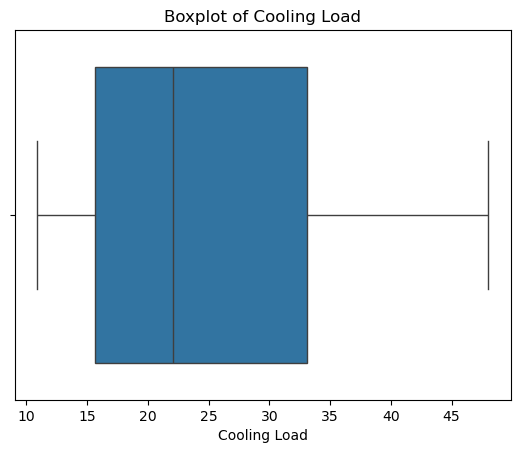

In [4]:
# checking for outliers
import seaborn as sns
import matplotlib.pyplot as plt
for i in df.select_dtypes(include='number'):
    sns.boxplot(x=df[i])
    plt.title(f"Boxplot of {i}")
    plt.show()

In [5]:
# Handling skewness
df.select_dtypes(include="number").skew()

Relative Compactness         0.495513
Surface Area                -0.125131
Wall Area                    0.533417
Roof Area                   -0.162764
Overall Height               0.000000
Orientation                  0.000000
Glazing Area                -0.060254
Glazing Area Distribution   -0.088689
Heating Load                 0.360449
Cooling Load                 0.395992
dtype: float64

In [6]:
df.duplicated().sum()

0

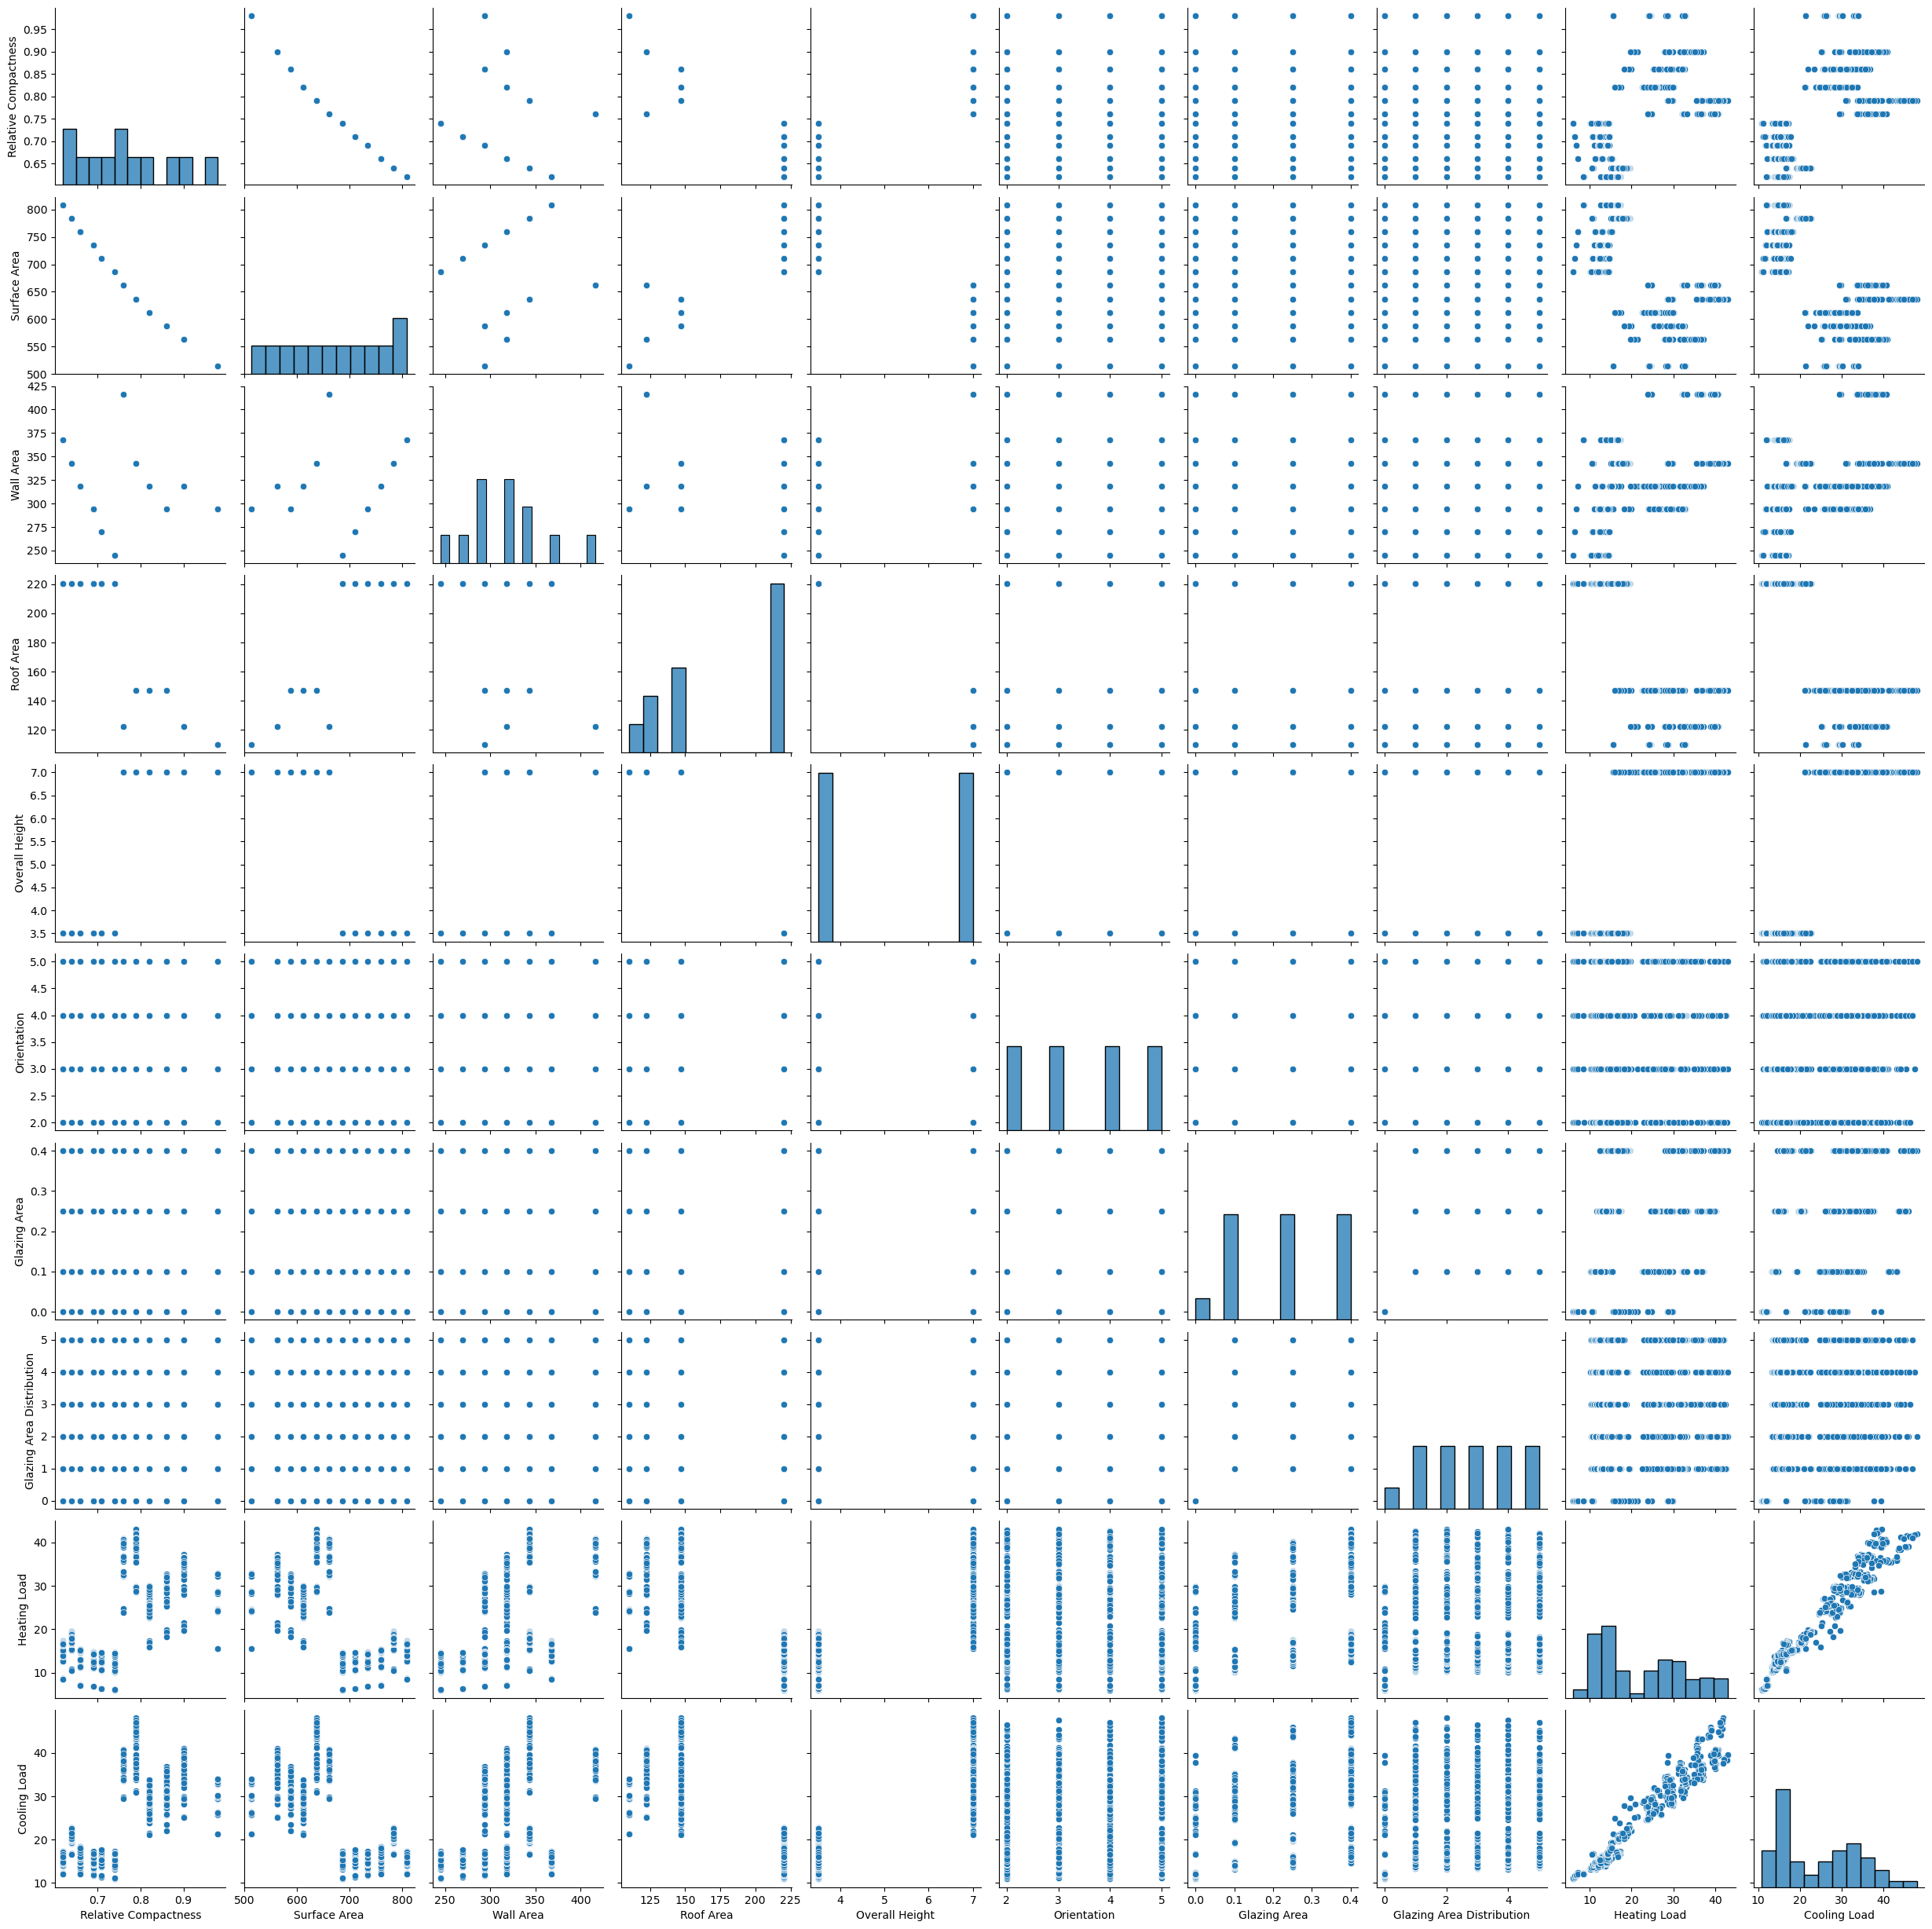

In [7]:
# for selection of model
sns.pairplot(df)

Model Building

In [8]:
X = df.drop("Cooling Load", axis=1)
y = df["Cooling Load"]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Baseline model
from sklearn.dummy import DummyRegressor
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
baseline_score = baseline.score(X_test, y_test)*100
print("Baseline R²:", baseline_score)

Baseline R²: -0.8408593861118474


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer
selector = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=6)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rfe", selector),
    ("power", PowerTransformer(method="yeo-johnson")),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=2,         
min_samples_leaf=2,          
max_leaf_nodes=5))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=DecisionTreeRegressor(),
                     n_features_to_select=6)),
                ('power', PowerTransformer()),
                ('model',
                 DecisionTreeRegressor(max_depth=10, max_leaf_nodes=5,
                                       min_samples_leaf=2, random_state=42))])

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = pipe.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

1.9738563035169112
6.404844389957061
0.930875940107694


In [13]:
pipe.score(X_train, y_train)*100 , pipe.score(X_test, y_test)*100

(94.17550239596815, 93.08759401076941)

In [16]:
import joblib
joblib.dump(pipe, "Energy_efficiency.pkl")


['Energy_efficiency.pkl']

In [15]:
# Get the mask of selected features
selected_mask = pipe.named_steps["rfe"].get_support()

# Original feature names (must be a DataFrame)
original_features = X_train.columns

selected_features = original_features[selected_mask]
print("Selected Features:", list(selected_features))


Selected Features: ['Relative Compactness', 'Wall Area', 'Orientation', 'Glazing Area', 'Glazing Area Distribution', 'Heating Load']
